# Advanced AI Insurance Notebook

This notebook aims to  build a regression model that predicts the insurance claim SettlementValue based on early‑stage claim information.

1. Data loading & initial inspection  
2. Exploratory Data Analysis (EDA)  
3. Data cleaning & feature engineering  

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Load data

In [121]:
data_path = "Synthetic_Data_For_Students (2).csv"  
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(5000, 36)


,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialReduction,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,...,Accident Date,Claim Date,Vehicle Age,Driver Age,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present,Gender
0,520.0,Rear end,E. 5 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2023-11-10 11:22:24.508901,2024-06-11 11:22:24.508901,13.0,33.0,4.0,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes,Male
1,870.0,Rear end,B. 2 months,0.0,0.0,0.0,520.0,0.0,0.0,90.0,...,2023-06-25 00:55:01.140228,2024-01-09 00:55:01.140228,4.0,45.0,2.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
2,2140.0,Other side pulled out of side road,G. 7 months,0.0,0.0,0.0,1400.0,0.0,0.0,0.0,...,2020-02-23 17:43:47.805561,2020-03-01 17:43:47.805561,9.0,45.0,4.0,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No,Female
3,520.0,Rear end - Clt pushed into next vehicle,D. 4 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-02 04:36:32.118423,2021-10-13 04:36:32.118423,5.0,62.0,1.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female
4,260.0,Rear end,C. 3 months,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2023-04-02 05:13:07.117423,2023-04-14 05:13:07.117423,9.0,78.0,1.0,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes,Other


## 2. Exploratory Data Analysis (EDA)

In [122]:
missing = df.isna().mean().sort_values(ascending=False) * 100 # get percentage of columns missing
missing.head(10)

Injury_Prognosis           3.12
SpecialJourneyExpenses     2.94
SpecialLoanerVehicle       2.78
Accident Date              2.76
GeneralUplift              2.74
SpecialAdditionalInjury    2.68
SpecialTherapy             2.64
SpecialHealthExpenses      2.60
SpecialUsageLoss           2.60
SpecialMedications         2.60
dtype: float64

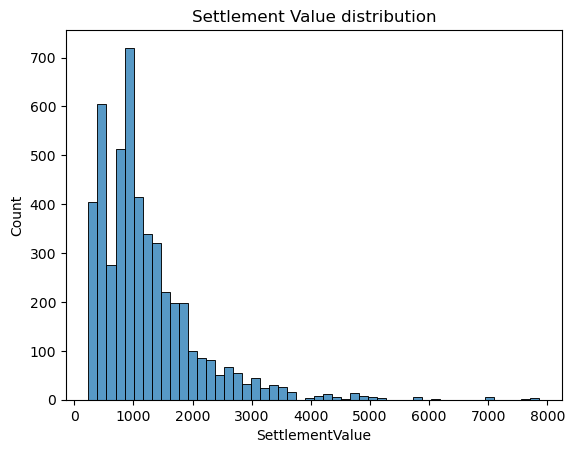

In [123]:
plt.figure()
sns.histplot(df['SettlementValue'].dropna(), bins=50)
plt.title('Settlement Value distribution')
plt.show()

We can see that SettlementValue is right‑skewed

Let's first inspect special columns, as we know that these mnay not be known at the time of claim

In [124]:
special_cols = [c for c in df.columns if c.lower().startswith('special')] # group special columns
general_cols = ['GeneralRest', 'GeneralUplift']
special_cols = special_cols + general_cols

special_summary = df[special_cols].describe().transpose() # Basic statistics
special_missing = df[special_cols].isnull().sum() # Missing values
special_zeros = (df[special_cols] == 0).sum() # How many are zero

special_corr_with_target = df[special_cols + ['SettlementValue']].corr()['SettlementValue'].drop('SettlementValue') # correlation

special_overview = pd.DataFrame({
    'Zeros': special_zeros,
    'Total Rows': len(df),
    'Percentage Zeros': (special_zeros / len(df)) * 100,
    'Mean': round(special_summary['mean']),
    'Std Dev': round(special_summary['std']),
    'Min': special_summary['min'],
    'Max': special_summary['max'],
    'CorrelationWithSettlementValue': round(special_corr_with_target, 2)
})

special_overview

,Zeros,Total Rows,Percentage Zeros,Mean,Std Dev,Min,Max,CorrelationWithSettlementValue
SpecialHealthExpenses,4854,5000,97.08,4.0,85.0,0.0,3024.00,0.02
SpecialReduction,4879,5000,97.58,0.0,0.0,0.0,0.00,NaN
SpecialOverage,4723,5000,94.46,13.0,84.0,0.0,1250.00,0.06
SpecialAdditionalInjury,4857,5000,97.14,0.0,13.0,0.0,889.00,0.01
SpecialEarningsLoss,4576,5000,91.52,52.0,393.0,0.0,7735.58,0.34
SpecialUsageLoss,4626,5000,92.52,9.0,66.0,0.0,1050.00,0.13
SpecialMedications,4832,5000,96.64,0.0,1.0,0.0,30.25,0.02
SpecialAssetDamage,4417,5000,88.34,33.0,283.0,0.0,6070.00,0.27
SpecialRehabilitation,4879,5000,97.58,0.0,1.0,0.0,21.20,-0.01
SpecialFixes,4869,5000,97.38,4.0,116.0,0.0,4000.00,0.11


As we can see, the majoirty of special costs for claims are 0. This being said, SpecialTherapy, SpecialEarningsLoss and SpecialAssetDamage do have some correlation to SettlementValue. 

For now, we will remove these columns for the initial model, as we can't expect the user to know them. But in future, if they can provide evidence, we could adjust/train a seperate model that considers this.

Similar to SpecialColumns,  we may not know general columns - so we can remove those - which should leave us with understandable numeric columns.

## 3. Feature Engineering

In [125]:
# create claim delay
df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')
df['Claim Date'] = pd.to_datetime(df['Claim Date'], errors='coerce')
df['ClaimDelayDays'] = (df['Claim Date'] - df['Accident Date']).dt.days

# turn into numerical feature
df['Injury_Prognosis_Months'] = df['Injury_Prognosis'].str.extract(r'(\d+)').astype(float) # Extract number of months from Injury_Prognosis

In [126]:
df_extra = df.copy()

df_extra['total special_cost'] = df_extra[special_cols].sum(axis=1)
df_extra['total_general_cost'] = df_extra[general_cols].sum(axis=1)

In [127]:
df = df.drop(columns=special_cols + general_cols + ['Accident Date', 'Claim Date', 'Injury_Prognosis'])

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

numeric_cols.remove('SettlementValue')  # target

print(f'Numeric: {numeric_cols}')
print(f'\nCategorical: {categorical_cols}')

print(df[categorical_cols].nunique())
print(f"Numeric cols: {len(numeric_cols)}, categorical cols: {len(categorical_cols)}")

Numeric: ['GeneralFixed', 'Vehicle Age', 'Driver Age', 'Number of Passengers', 'ClaimDelayDays', 'Injury_Prognosis_Months']

Categorical: ['AccidentType', 'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash', 'Vehicle Type', 'Weather Conditions', 'Accident Description', 'Injury Description', 'Police Report Filed', 'Witness Present', 'Gender']
AccidentType                  18
Exceptional_Circumstances      2
Minor_Psychological_Injury     2
Dominant injury                4
Whiplash                       2
Vehicle Type                   3
Weather Conditions             3
Accident Description           5
Injury Description             5
Police Report Filed            2
Witness Present                2
Gender                         3
dtype: int64
Numeric cols: 6, categorical cols: 12


### Handle missing values

In [128]:
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"After one-hot encoding: {df_encoded.shape}")

df_encoded.to_csv('PreprocessedJack.csv', index=False)

After one-hot encoding: (5000, 55)


In [129]:
df_extra = df_extra.drop(columns=special_cols + general_cols + ['Accident Date', 'Claim Date', 'Injury_Prognosis'])

numeric_cols = df_extra.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_extra.select_dtypes(include=['object']).columns.tolist()

numeric_cols.remove('SettlementValue')  # target

print(f'Numeric: {numeric_cols}')
print(f'\nCategorical: {categorical_cols}')

#print(df[categorical_cols].nunique())
print(f"Numeric cols: {len(numeric_cols)}, categorical cols: {len(categorical_cols)}")

df_extra[numeric_cols] = df_extra[numeric_cols].fillna(df_extra[numeric_cols].median())
df_extra[categorical_cols] = df_extra[categorical_cols].fillna('Unknown')

Numeric: ['GeneralFixed', 'Vehicle Age', 'Driver Age', 'Number of Passengers', 'ClaimDelayDays', 'Injury_Prognosis_Months', 'total special_cost', 'total_general_cost']

Categorical: ['AccidentType', 'Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash', 'Vehicle Type', 'Weather Conditions', 'Accident Description', 'Injury Description', 'Police Report Filed', 'Witness Present', 'Gender']
Numeric cols: 8, categorical cols: 12


### Encode

In [130]:
#EXTRA
df_extra_encoded = pd.get_dummies(df_extra, columns=categorical_cols, drop_first=True)

print(f"After one-hot encoding: {df_extra_encoded.shape}")

df_extra_encoded.to_csv('PreprocessedJackExtra.csv', index=False)

After one-hot encoding: (5000, 57)


In [119]:
df_extra

,SettlementValue,AccidentType,GeneralFixed,Exceptional_Circumstances,Minor_Psychological_Injury,Dominant injury,Whiplash,Vehicle Type,Weather Conditions,Vehicle Age,...,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present,Gender,ClaimDelayDays,Injury_Prognosis_Months,total special_cost,total_general_cost
0,520.00,Rear end,520.0,No,Yes,Arms,Yes,Motorcycle,Rainy,13.0,...,4.0,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes,Male,214.0,5.0,0.00,0.0
1,870.00,Rear end,260.0,No,Yes,Multiple,Yes,Motorcycle,Snowy,4.0,...,2.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female,198.0,2.0,610.00,520.0
2,2140.00,Other side pulled out of side road,840.0,No,No,Legs,Yes,Motorcycle,Sunny,9.0,...,4.0,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No,Female,7.0,7.0,1400.00,1400.0
3,520.00,Rear end - Clt pushed into next vehicle,520.0,No,Yes,Arms,Yes,Truck,Rainy,5.0,...,1.0,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes,Female,11.0,4.0,0.00,0.0
4,260.00,Rear end,260.0,No,Yes,Arms,No,Motorcycle,Rainy,9.0,...,1.0,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes,Other,12.0,3.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,275.00,Other side turned across Clt's path,260.0,No,Yes,Legs,No,Truck,Snowy,18.0,...,3.0,Hit a deer on the highway.,Concussion and bruised ribs.,No,No,Other,309.0,1.0,118.50,0.0
4996,1074.35,Other side pulled out of side road,895.0,No,Unknown,Hips,Unknown,Truck,Snowy,10.0,...,4.0,Side collision at an intersection.,Fractured arm and leg.,Yes,No,Female,14.0,8.0,247.35,0.0
4997,2020.00,Other side pulled out of side road,520.0,No,Yes,Arms,No,Car,Sunny,11.0,...,1.0,Swerved to avoid another vehicle.,Minor cuts and scrapes.,No,Yes,Male,149.0,6.0,2020.00,2020.0
4998,781.20,Rear end - 3 car - Clt at front,520.0,No,Yes,Hips,No,Car,Rainy,10.0,...,1.0,Lost control on a snowy road.,Sprained ankle and wrist.,No,No,Female,251.0,4.0,366.20,0.0
